# Common link
* [Load Data](#load-data)
* [Split Data](#split-dataset)
* [Model](#model)
* [Evaluation](#evaluation)

In [1]:
feature = 29

# Model

In [2]:
from tensorflow.keras import layers
import tensorflow.keras as keras
import tensorflow.keras.backend as K

In [3]:
g_e, g, feature_extractor, d = None, None, None, None
gan_trainer = None
RAT = 115

## Generators Encoder


In [4]:
def define_GE():
    input_layer = layers.Input(name='input', shape=(feature))
    #x = layers.Reshape((height, width, channels), name='ge_reshape')(input_layer)

    # Encoder
    x = layers.Dense(1024, name='ge_dense_1')(input_layer)
    x = layers.LeakyReLU(name='ge_leaky_1')(x)

    x = layers.Dense(512, name='ge_dense_2')(x)
    x = layers.LeakyReLU(name='ge_leaky_2')(x)

    x = layers.Dense(256, name='ge_dense_3')(x)
    x = layers.LeakyReLU(name='ge_leaky_3')(x)

    x = layers.Dense(128, name='ge_dense_4')(x)
    x = layers.LeakyReLU(name='ge_leaky_4')(x)

    #x = layers.GlobalAveragePooling2D(name='g_encoder_output')(x)

    g_e = keras.models.Model(inputs=input_layer, outputs=x)

    #g_e.summary()
    return g_e

## Generator

In [5]:
def define_G(g_e):
    input_layer = layers.Input(name='input', shape=(feature))

    x = g_e(input_layer)

    #y = layers.Reshape((height // 6, width // 6, 128), name='de_reshape1')(x) # 256 = 256 * (6/6) * (6/6) 

    y = layers.Dense(256, name='dense_1')(x)
    y = layers.LeakyReLU(name='leaky_1')(y)

    y = layers.Dense(512, name='dense_2')(y)
    y = layers.LeakyReLU(name='leaky_2')(y)

    y = layers.Dense(1024, name='dense_3')(y)
    y = layers.LeakyReLU(name='leaky_3')(y)

    y = layers.Dense(feature, name='dense_4')(y)
    y = layers.LeakyReLU(name='leaky_4')(y)

    #y = layers.Flatten()(y)
    #y = layers.Dense(36, name='dense')(y)
    #y = layers.Reshape((height, width, channels), name='de_reshape2')(y)

    g = keras.models.Model(inputs=input_layer, outputs=y)

    #g.summary()
    
    return g

## discriminator

In [6]:
def define_D():
    input_layer = layers.Input(name='input', shape=(feature))

    f = layers.Dense(1024, name='f_dense_1')(input_layer)
    f = layers.LeakyReLU(name='f_leaky_1')(f)

    f = layers.Dense(512, name='f_dense_2')(f)
    f = layers.LeakyReLU(name='f_leaky_2')(f)

    f = layers.Dense(256, name='f_dense_3')(f)
    f = layers.LeakyReLU(name='f_leaky_3')(f)

    f = layers.Dense(128, name='f_dense_4')(f)
    f = layers.LeakyReLU(name='feature_output')(f)
    
    #f = feature_extractor(input_layer)

    #d = layers.Dense(16, name='d_dense_1')(f)
    d = layers.Dense(1, activation='sigmoid', name='d_out')(f)
        
    d = keras.models.Model(input_layer, d)
    #d.summary()
    d.compile(optimizer='adam', loss='binary_crossentropy')
    
    return d

## gan trainer

In [7]:
import tensorflow as tf
class AdvLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AdvLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        y_pred = d(x[1])
        y_true = tf.ones_like(y_pred)
        return keras.losses.binary_crossentropy(y_true,y_pred)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class CntLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CntLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.abs(ori - gan))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class EncLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EncLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.square(g_e(ori) - g_e(gan)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)

# loss function
def loss(yt, yp):
    return yp

In [8]:
def define_gan_trainer():
    # model for training
    input_layer = layers.Input(name='input', shape=(feature))
    gan = g(input_layer) # g(x)

    adv_loss = AdvLoss(name='adv_loss')([input_layer, gan])
    cnt_loss = CntLoss(name='cnt_loss')([input_layer, gan])
    enc_loss = EncLoss(name='enc_loss')([input_layer, gan])

    gan_trainer = keras.models.Model(input_layer, [adv_loss, cnt_loss, enc_loss])

    losses = {
        'adv_loss': loss,
        'cnt_loss': loss,
        'enc_loss': loss,
    }

    lossWeights = {'cnt_loss': 40.0, 'adv_loss': 1.0, 'enc_loss': 1.0}
    
    # compile
    gan_trainer.compile(optimizer = 'adam', loss=losses, loss_weights=lossWeights)
    #gan_trainer.summary()
    
    return gan_trainer

# Training

In [9]:
import numpy as np
niter = 1000
bz = 512

In [10]:
def get_data_generator(data, batch_size=32):
    datalen = len(data)
    cnt = 0
    while True:
        idxes = np.arange(datalen)
        np.random.shuffle(idxes)
        cnt += 1
        for i in range(int(np.ceil(datalen/batch_size))):
            train_x = np.take(data, idxes[i*batch_size: (i+1) * batch_size], axis=0)
            y = np.ones(len(train_x))
            yield train_x, [y, y, y]

In [11]:
def train(x_train):
    train_data_generator = get_data_generator(x_train, bz)
    for i in range(niter):
        
        ### get batch x, y ###
        x, y = train_data_generator.__next__()
            
        ### train disciminator ###
        d.trainable = True

        #print(x.shape)
            
        fake_x = g.predict(x)
            
        d_x = np.concatenate([x, fake_x], axis=0)
        d_y = np.concatenate([np.zeros(len(x)), np.ones(len(fake_x))], axis=0)
            
        d_loss = d.train_on_batch(d_x, d_y)

        ### train generator ###
        
        d.trainable = False        
        g_loss = gan_trainer.train_on_batch(x, y)
        
        if i % 100 == 0:
            print(f'niter: {i+1}, g_loss: {g_loss}, d_loss: {d_loss}')

# Evaluation

In [12]:
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, average_precision_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

TPR_res, FPR_res, P_res, R_res = [], [], [], []
AUC_res, AUPRC_res = [], []
accuracies, fscore_res, recall_res, precision_res = [], [], [], []
reports = []
scores = []
THR_opt = []

lat_weight = 0.1
recons_weight = 1-lat_weight

def evaluation(x_test,y_test):
    encoded = g_e.predict(x_test)
    gan_x = g.predict(x_test)
    encoded_gan = g_e.predict(gan_x)
    recons_loss = np.mean(np.absolute(gan_x - x_test), axis=-1)
    lat_loss = np.mean(np.square(encoded - encoded_gan), axis=-1)
    print('LATloss:',lat_loss.shape)
    print('RECloss:',recons_loss.shape)
    score = lat_weight*lat_loss + recons_weight*recons_loss
    #score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1
    print('Scores:',score.shape)
    score = score.reshape(len(score))

    nScore, abnScore = score[y_test==0], score[y_test==1]
    print('Scores of Normal and Abnormal:',nScore.shape,abnScore.shape)
    scores.append([nScore,abnScore])


    score = score.reshape(len(score))
    fpr, tpr, threshold_auc = roc_curve(y_score=score, y_true=y_test, pos_label=1)
    TPR_res.append(tpr)
    FPR_res.append(fpr)
    precision, recall, threshold_prc = precision_recall_curve(probas_pred=score, y_true=y_test, pos_label=1)
    P_res.append(precision)
    R_res.append(recall)

    auc_score = auc(fpr,tpr)
    auprc_score = auc(recall, precision)
    AUC_res.append(auc_score)
    AUPRC_res.append(auprc_score)


    # optimal cut off point would be where “true positive rate” is high and the “false positive rate” is low.
    J = tpr - fpr
    ix1 = np.argmax(J)
    optimal_threshold = threshold_auc[ix1]
    #optimal_threshold = sorted(list(zip(np.sqrt(tpr-fpr), threshold_auc)), key=lambda i: i[0], reverse=False)[0][1]
    print('Optimal threshold for best AUC:',optimal_threshold, 'TPR-FPR=',J[ix1])

    fscore = (2 * precision * recall) / (precision + recall)
    ix2 = np.nanargmax(fscore)
    optimal_prc_threshold = threshold_prc[ix2]
    #optimal_prc_threshold = sorted(list(zip(np.abs(precision - recall), threshold_prc)), key=lambda i: i[0], reverse=False)[0][1]
    print('Optimal threshold for best AUPRC:',optimal_prc_threshold,'f-score=', fscore[ix2])
    
    fscore_res.append(fscore[ix2])
    recall_res.append(recall[ix2])
    precision_res.append(precision[ix2])

    THR_opt.append({'AUC':optimal_threshold, 'PRC':optimal_prc_threshold})
    
    yTest_predict = [0 if s<=optimal_prc_threshold else 1 for s in score]
    class_report = classification_report(y_pred=yTest_predict, y_true=y_test, digits=4, output_dict=True)
    
    reports.append(class_report)
    accuracies.append(class_report['accuracy'])


# K-Fold Train

In [13]:
TOTAL_RUN = 10
run = 1

for run in range(1,TOTAL_RUN+1):
    g_e = define_GE()
    g = define_G(g_e)
    d = define_D()
    gan_trainer = define_gan_trainer()
    
    print('run: {!r}'.format(run))
    datasets = np.load('data/Runs/{!s}_{!s}_Runs/Run_{!s}.npz'.format(RAT,TOTAL_RUN, run))
    x_train, y_train = datasets['trainX'], datasets['trainY']
    x_test, y_test = datasets['testX'], datasets['testY']
    print('train:',x_train.shape,y_train.shape,'; ','test:',x_test.shape,y_test.shape)
    train(x_train=x_train)
    evaluation(x_test=x_test, y_test=y_test)
    run+=1

run: 1
train: (227452, 29) (227452,) ;  test: (57355, 29) (57355,)
niter: 1, g_loss: [25.946544647216797, 0.6993457674980164, 0.6308907866477966, 0.011565975844860077], d_loss: 0.6965380907058716
niter: 101, g_loss: [5.679062366485596, 0.00028084786026738584, 0.14160364866256714, 0.014635458588600159], d_loss: 0.03558129817247391
niter: 201, g_loss: [4.192737102508545, 0.12618491053581238, 0.10147084295749664, 0.00771857425570488], d_loss: 0.09775805473327637
niter: 301, g_loss: [3.914294958114624, 0.01676146313548088, 0.09724535048007965, 0.007719660643488169], d_loss: 0.0274309441447258
niter: 401, g_loss: [3.4819953441619873, 0.11177308857440948, 0.08407142013311386, 0.007365451194345951], d_loss: 0.0762602835893631
niter: 501, g_loss: [2.9602949619293213, 0.03576295077800751, 0.07300689816474915, 0.004255989566445351], d_loss: 0.03822916001081467
niter: 601, g_loss: [2.872856616973877, 0.024728693068027496, 0.07111053913831711, 0.0037062233313918114], d_loss: 0.030710434541106224
n

# Retrain
* [back to model](#model)

# AUC and PR curve

0.5


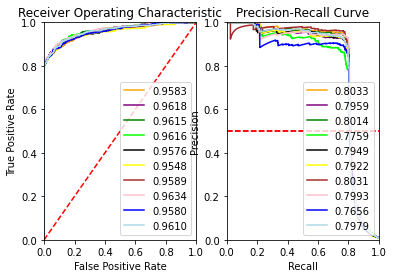

Average AUC score =  0.9596801340663459
Average AUPRC score =  0.7929418341139693
Average f1 score =  0.8436973927605361
Average recall =  0.7825203252032521
Average precision =  0.9157870796408073
Average accuracy =  0.9974928079504839
[{'AUC': 0.13567157379307762, 'PRC': 0.7083172876477581}, {'AUC': 0.12166523325887933, 'PRC': 0.6665114580171005}, {'AUC': 0.14234847487343655, 'PRC': 0.6884369276835818}, {'AUC': 0.10838534634186683, 'PRC': 0.7679644409696638}, {'AUC': 0.1173130995894482, 'PRC': 0.5783607572733686}, {'AUC': 0.1112682006958524, 'PRC': 0.7117917392716961}, {'AUC': 0.12735594842776726, 'PRC': 0.7313111872387249}, {'AUC': 0.1542604504636259, 'PRC': 0.6030088375108008}, {'AUC': 0.10742999738746593, 'PRC': 0.7529652686850759}, {'AUC': 0.13837718812916333, 'PRC': 0.6267879674651627}]


In [14]:
rcParams['figure.figsize'] = 20, 5
#plot
fig, ax=plt.subplots(1,2)
proportion_of_abn = 0.5

colors = ['orange','purple','green','lime','black','yellow','brown','pink','blue','lightblue']
print(proportion_of_abn)


for i in range(len(TPR_res)):
    tpr, fpr = TPR_res[i], FPR_res[i]
    precision, recall = P_res[i], R_res[i]
    auc_score, auprc_score = AUC_res[i], AUPRC_res[i]
    indicator = colors[i]

    #ROC curve
    ax[0].plot(fpr, tpr, color = indicator, label = '%0.4f' % auc_score)
    ax[0].legend(loc = 'lower right')

    #PR curve
    ax[1].plot(recall, precision, color = indicator, label='%0.4f' % auprc_score)
    ax[1].legend(loc = 'lower right')
    


ax[0].set_title('Receiver Operating Characteristic')
ax[0].plot([0, 1], [0, 1],'r--')
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_ylabel('True Positive Rate')
ax[0].set_xlabel('False Positive Rate')

ax[1].set_title('Precision-Recall Curve')
ax[1].plot([0, 1], [proportion_of_abn, proportion_of_abn],'r--')
ax[1].plot([0, 1], [proportion_of_abn, proportion_of_abn],'r--')
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
ax[1].set_ylabel('Precision')
ax[1].set_xlabel('Recall')
plt.show()

#calculate average AUC and AUPRC score
print('Average AUC score = ',sum(AUC_res) / TOTAL_RUN)
print('Average AUPRC score = ',sum(AUPRC_res) / TOTAL_RUN)
print('Average f1 score = ',sum(fscore_res) / TOTAL_RUN)
print('Average recall = ',sum(recall_res) / TOTAL_RUN)
print('Average precision = ',sum(precision_res) / TOTAL_RUN)
print('Average accuracy = ', sum(accuracies)/TOTAL_RUN)

print(THR_opt)

#print optnimal thresholds of 10 folds
#print(THR_opt)

In [15]:
TPR_maxlen = FPR_maxlen = P_maxlen = R_maxlen = 0

for i in range(len(TPR_res)):
    if TPR_maxlen < len(TPR_res[i]): TPR_maxlen = len(TPR_res[i])
    if FPR_maxlen < len(FPR_res[i]): FPR_maxlen = len(FPR_res[i])
    if P_maxlen < len(P_res[i]): P_maxlen = len(P_res[i])
    if R_maxlen < len(R_res[i]): R_maxlen = len(R_res[i])

def AddOn(addTo,data,row, dataLen):
    tmp = data[0]
    for i in range(dataLen):
        if i<len(data[row]) and data[row][i] is not np.nan: tmp = data[row][i]
        addTo[i]+=tmp

def AVG(data):
    return (data / TOTAL_RUN).tolist()
TPR_avg, FPR_avg, P_avg, R_avg = np.zeros((TPR_maxlen)), np.zeros((FPR_maxlen)), np.zeros((P_maxlen)), np.zeros((R_maxlen))

for i in range(len(TPR_res)):
    AddOn(TPR_avg, TPR_res, i, TPR_maxlen)
    AddOn(FPR_avg, FPR_res, i, FPR_maxlen)
    AddOn(P_avg, P_res, i, P_maxlen)
    AddOn(R_avg, R_res, i, R_maxlen)
    
TPR_avg, FPR_avg, P_avg, R_avg = AVG(TPR_avg), AVG(FPR_avg), AVG(P_avg), AVG(R_avg)

# Save Result to json

In [17]:
import json

with open('data/Runs/{!s}_{!s}_Runs/result.json'.format(RAT,TOTAL_RUN, run), "r", encoding='utf-8') as jsonFile:
    data = json.load(jsonFile)

with open('data/Runs/{!s}_{!s}_Runs/result.json'.format(RAT,TOTAL_RUN, run), 'w', encoding='utf-8') as jsonFile:
    data['FinGANomaly_{!s}'.format(lat_weight)] = {
            'AUC': AUC_res,
            'AUPRC': AUPRC_res,
            'Fscore': fscore_res,
            'Recall': recall_res,
            'Precision': precision_res,
            'Accuracy': accuracies,
            'THR_opt': THR_opt,
            'AVG': {
                'TPR': TPR_avg,
                'FPR': FPR_avg,
                'P': P_avg,
                'R': R_avg
            }
        }
    
    json.dump(data, jsonFile, ensure_ascii=False)

# End of Jupyter
* [To top](#common-link)